# VEP pilot PacBio sequencing 
This example shows how to process PacBio circular consensus sequencing of a PacBio run containing VEP sequences from several different VEPs. 

Here we only analyzed two VEPs and use only a snippet of the full data set of circular consensus sequences so that the example is small and fast.

## Set up for analysis
Import necessary Python modules:

In [1]:
import os
import tempfile
import warnings

import Bio.SeqIO

import pandas as pd

import pysam

import alignparse.ccs
import alignparse.minimap2
import alignparse.targets
import alignparse.cs_tag

Suppress warnings that clutter output:

In [2]:
warnings.simplefilter('ignore')

Directory for output:

In [3]:
outdir = './output_files/'
os.makedirs(outdir, exist_ok=True)

## Target amplicon
We have performed sequencing of several VEP amplicons that include VEP sequences along with a PacBio index and several other features.
The amplicons are defined as Genbank files.
First, let's just look at the files:

In [4]:
wt_targetfile = 'input_files/LASV_G1959_WT.gb'
opt_targetfile = 'input_files/LASV_G1959_OPT.gb'


for targetfile in [wt_targetfile, opt_targetfile]:
    with open(targetfile) as f:
        print(f.read())

LOCUS       LASV_G1959_WT           1730 bp ds-DNA     linear       14-JUN-2019
DEFINITION  .
ACCESSION   
VERSION     
SOURCE      Kate Dusenbury
  ORGANISM  .
COMMENT     PacBio amplicon for LASV G1959 WT sequence
COMMENT     There are single nucleotide tags in the 5' and 3' termini to measure strand exchange.
FEATURES             Location/Qualifiers
     T2A             85..147
                     /label="T2A"
     ZsGreen         15..84
                     /label="ZsGreen"
     termini3        1639..1730
                     /label="3'Termini"
     index           9..14
                     /label="sample_index"
     leader5         1..8
                     /label="5' leader"
     termini5        1..147
                     /label="5'Termini"
     variant_tag5    34..34
                     /variant_1=T
                     /variant_2=C
                     /label="5'VariantTag"
     variant_tag3    1702..1702
                     /variant_1=G
                     /variant_2=A
 

Read the amplicons into a `Targets` object, specifying the features that we require the target to contain:

In [5]:
targets = alignparse.targets.Targets(seqsfile=[wt_targetfile, opt_targetfile],
                  req_features=['termini5', 'gene', 'spacer', 'index',
                                'termini3', 'variant_tag5', 'variant_tag3'],
                  allow_extra_features=True)

targets.get_target('LASV_G1959_WT')

Target(name=LASV_G1959_WT, seq=GACTGATANNNNNNCAGCGACGCCAAGAACCAGYAGTGGCACCTGACCGAGCACGCCATCGCCTCCGGCTCCGCCTTGCCCGCTGGATCCGGCGAGGGCAGAGGAAGTCTGCTAACATGCGGTGACGTCGAGGAGAATCCTGGCCCAATGGGACAGATAGTGACATTCTTCCAGGAAGTACCTCATGTGATAGAAGAGGTGATGAACATTGTCCTCATTGCACTGTCTATACTAGCAGTGCTGAAAGGTCTGTACAATTTTGCAACATGTGGCCTCGTTGGTTTGGTTACCTTCCTCCTGTTGTGTGGCAGGTCTTGCACAACCAGTCTTTACAAAGGGGTCTATGAGCTTCAGACTCTGGAATTAAACATGGAGACACTCAATATGACCATGCCCCTCTCCTGTACAAAGAACAACAGTCATCATTATATTATGGTGGGTAATGAGACAGGTCTAGAGCTGACCTTGACCAACACGAGCATCATTAATCATAAATTTTGCAATCTGTCTGATGCCCACAAAAAGAACCTCTATGATCACGCTCTTATGAGCATAATTTCAACTTTCCATCTGTCCATTCCCAACTTCAATCAGTATGAGGCAATGAGCTGTGATTTCAATGGGGGAAAGATTAGTGTGCAGTACAACCTGAGTCACAGTTATGCTGGGGATGCGGCCAACCATTGTGGCACTGTTGCAAATGGTGTCCTACAGACCTTCATGAGGATGGCTTGGGGTGGAAGCTACATTGCTCTTGACTCAGGCCATGGCAGGTGGGACTGCATTATGACTAGTTATCAGTACCTGATAATCCAAAATACAACCTGGGAAGATCACTGCCAGTTCTCAAGACCATCTCCCATCGGCTATCTCGGACTCCTCTCACAAAGGACCAGAGATATTTATATTAGTAGAAGACTACTAGGCACATTCACATGGACACTGTCAGATTCTGAAGGTAAGGACACA

Plot the targets:

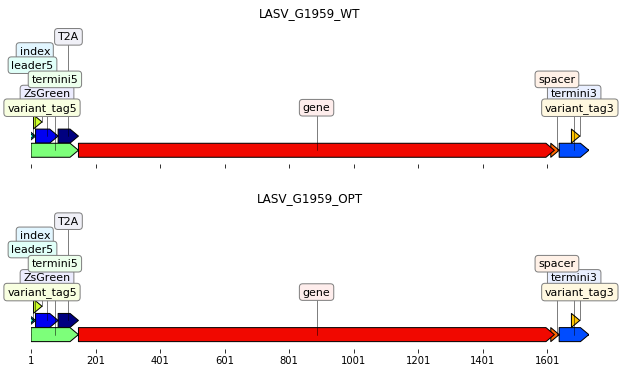

In [6]:
_ = targets.plot(ax_width=10)

We can write them to a file for alignment:

## PacBio CCSs
We will align PacBio circular consensus sequences (CCSs) to the target.
First, we want to look at the CCSs.
A FASTQ file with these CCSs along with an associated report file were generated using the PacBio `ccs` program (see [here](https://github.com/PacificBiosciences/ccs) for details on `ccs`) using commands like the following (generates report file and BAM of CCSs):

    ccs --minLength 50 --maxLength 5000 \
        --minPasses 3  --minPredictedAccuracy 0.999 \
        --reportFile vep_pilot_report.txt \
        --polish --numThreads 16 \
        vep_pilot_subreads.bam vep_pilot_ccs.bam
        
The BAM file was then converted to a FASTQ file using [samtools](http://www.htslib.org/) with flags to retain the number of passes (`np`) and read quality (`rq`) flags:

    samtools bam2fq -T np,rq vep_pilot_ccs.bam > vep_pilot_ccs.fastq
    
Here is a data frame with the resulting FASTQ and BAM files:

In [7]:
run_names = ['vep_pilot']
ccs_dir = 'input_files'

pacbio_runs = pd.DataFrame(
            {'name': run_names,
             'report': [f"{ccs_dir}/{name}_report.txt" for name in run_names],
             'fastq': [f"{ccs_dir}/{name}_ccs.fastq" for name in run_names]
             })

pacbio_runs

,name,report,fastq
0,vep_pilot,input_files/vep_pilot_report.txt,input_files/vep_pilot_ccs.fastq


We create a `Summaries` object for these CCSs:

In [8]:
ccs_summaries = alignparse.ccs.Summaries(pacbio_runs)

Plot how many ZMWs yielded CCSs:

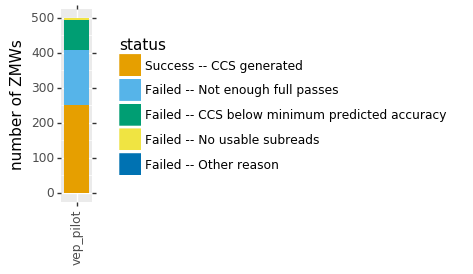

In [9]:
p = ccs_summaries.plot_zmw_stats()
_ = p.draw()

Statistics on the CCSs (length, number of subread passes, quality):

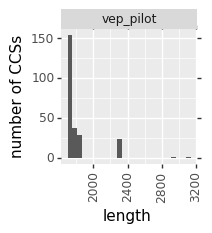

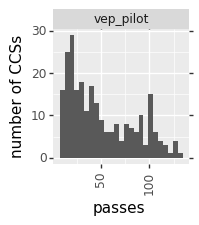

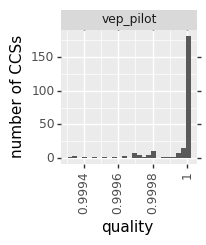

In [10]:
for stat in ['length', 'passes', 'quality']:
    p = ccs_summaries.plot_ccs_stats(stat)
    _ = p.draw()

## Align CCSs to target
Now we use `minimap2` to align the CCSs to the target.

First, we create a `Mapper` object to run `minimap2`, using the options for codon-level deep mutational scanning:

In [11]:
mapper = alignparse.minimap2.Mapper(
            options=alignparse.minimap2.OPTIONS_CODON_DMS)

print(f"Using `minimap2` {mapper.version} with these options:\n{' '.join(mapper.options)}")

Using `minimap2` 2.17-r941 with these options:
-A2 -B4 -O12 -E2 --end-bonus=13 --score-N=4 --secondary=no --cs


Now use this mapper to do the alignments to a SAM file.
First, add the names of the desired alignment files to our data frame:

In [12]:
pacbio_runs = pacbio_runs.assign(alignments=lambda x: outdir + x['name'] + '_alignments.sam')

pacbio_runs

,name,report,fastq,alignments
0,vep_pilot,input_files/vep_pilot_report.txt,input_files/vep_pilot_ccs.fastq,./output_files/vep_pilot_alignments.sam


Now use the mapper to actually align the FASTQ queries to the target:

In [13]:
for tup in pacbio_runs.itertuples(index=False):
    print(f"Aligning {tup.fastq} to create {tup.alignments}...")
    targets.align(queryfile=tup.fastq,
                  alignmentfile=tup.alignments,
                  mapper=mapper)

Aligning input_files/vep_pilot_ccs.fastq to create ./output_files/vep_pilot_alignments.sam...


These SAM files now contain the alignments along with the [`cs` tag](https://github.com/lh3/minimap2#cs), which contains details on the mutations:

In [14]:
for fname in pacbio_runs['alignments'][:1]:
    with pysam.AlignmentFile(fname) as f:
        a = next(f)
        print(f"First alignment in {fname} has following `cs` tag:\n\n{a.get_tag('cs')}\n\n"
         f"and the following full line:\n\n{a.to_string()}"
         )

First alignment in ./output_files/vep_pilot_alignments.sam has following `cs` tag:

:8*nt*nc*nc*ng*nt*nt:19*nc:117

and the following full line:

m54228_190605_190010/4194380/ccs	16	LASV_G1959_OPT	1	0	151M1678S	*	0	0	GACTGATATCCGTTCAGCGACGCCAAGAACCAGCAGTGGCACCTGACCGAGCACGCCATCGCCTCCGGCTCCGCCTTGCCCGCTGGATCCGGCGAGGGCAGAGGAAGTCTGCTAACATGCGGTGACGTCGAGGAGAATCCTGGCCCAATGGTTCCTCAGGTTCTTTTGTTTGTACCCCTTCTGGGTTTTTCGTTGTGTTTCGGGAAGTTCCCCATTTACACGATACCAGACGAACTTGGTCCCTGGAGCCCTATTGACATACACCATCTCAGCTGTCCAAATAACCTGGTTGTGGAGGATGAAGGATGTACCAACCTGTCCGAGTTCTCCTACATGGAACTCAAAGTGGGATACATCTCAGCCATCAAAGTGAACGGGTTCACTTGCACAGGTGTTGTGACAGAGGCAGAGACCTACACCAACTTTGTTGGTTATGTCACAACCACATTCAAGAGAAAGCATTTCCGCCCCACCCCAGACGCATGTAGAGCCGCGTATAACTGGAAGATGGCCGGTGACCCCAGATATGAAGAGTCCCTACACAATCCATACCCCGACTACCACTGGCTTCGAACTGTAAGAACCACCAAAGAGTCCCTCATTATCATATCCCCAAGTGTGACAGATTTGGACCCATATGACAAATCCCTTCACTCAAGGGTCTTCCCTGGCGGAAAGTGCTCAGGAATAACGGTGTCCTCTACCTACTGCTCAACTAACCATGATTACACCATTTGGATGCCCGAGGATCCGAGACCAAGGACACCTTGTAACATTTTTACC

For this first aligned segment, let's look at the cs tag and print out the feature names and feature cs tags for the features in the aligned target.

Note: This first alignment is not a LASV_G1959 GP read, so only the 5' terminus aligns.

In [30]:
if a.is_unmapped:
        pass  # cannot currently handle unmapped
vep_alignment = alignparse.cs_tag.Alignment(a)
for target in targets.targets:
    if vep_alignment.target_name == target.name:
        print(vep_alignment.cs)
        for feature in target.features:
            feat_cs = vep_alignment.extract_cs(feature.start, feature.end)
            print(feature.name)
            print(feat_cs)

:8*nt*nc*nc*ng*nt*nt:19*nc:117
T2A
(':63', 0, 0)
ZsGreen
(':19*nc:50', 0, 0)
termini3
None
index
('*nt*nc*nc*ng*nt*nt', 0, 0)
leader5
(':8', 0, 0)
termini5
(':8*nt*nc*nc*ng*nt*nt:19*nc:113', 0, 0)
variant_tag5
('*nc', 0, 0)
variant_tag3
None
spacer
None
gene
(':4', 0, 1472)
